In [1]:
import sys
sys.path.append('../src/')
from vi_hrg_approx_vMF2D import *
from utils import c2d, hyperdist, p_hd, polar2cart, warn_tensor, unit_circle
from torch import autograd
torch.manual_seed(4)

In [2]:
def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R.item()-epsilon)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

In [4]:
logit = lambda x: (x/(1-x)).log()

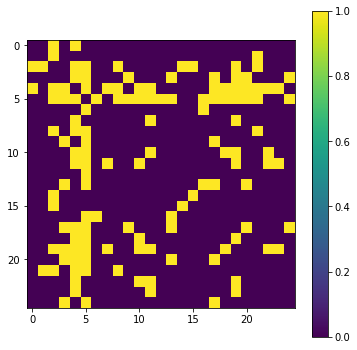

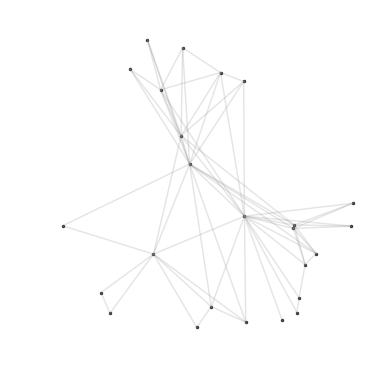

In [5]:
N = 25
R = torch.tensor([6.0]).double()
alpha = .7
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
G.show()
G.plot()

In [6]:
r_init = noise_r(r, R, rel_var=0.05)
phi_init = noise_phi(theta, 0.05)

r_loc_init = logit(r_init/R)*R/5
r_scale_init = torch.ones([N]).double().log()
phi_loc_init = polar2cart(1, phi_init)

In [7]:
R_conc_init = torch.tensor(10.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([3.,10.]).log()

In [8]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N, shuffle=True, num_workers=0)
vi = VI_HRG(N,10, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':None, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init})
vi.dataloader = dataloader
vi.optimizer = torch.optim.RMSprop(vi.parameters())
#vi.optimizer.lr

In [9]:
with autograd.detect_anomaly():
    vi.train(dataloader, lrs=0.1, debug=False, epochs=30)
    vi.train(dataloader, lrs=0.01, debug=False, epochs=30)

>>>>>>>>>>>> Start training...


../src/utils.py:126: UserWarning: p_raw has 1 in it!
  warnings.warn(str('%s has 1 in it!' % variable))


Epoch 1 | LR: 0.10 | Total loss: 659.34 | Epoch time 2.98
Epoch 2 | LR: 0.10 | Total loss: 428.85 | Epoch time 2.55
Epoch 3 | LR: 0.10 | Total loss: 402.34 | Epoch time 2.53
Epoch 4 | LR: 0.10 | Total loss: 381.57 | Epoch time 2.50
Epoch 5 | LR: 0.10 | Total loss: 373.42 | Epoch time 2.57
Epoch 6 | LR: 0.10 | Total loss: 373.02 | Epoch time 2.54
Epoch 7 | LR: 0.10 | Total loss: 363.42 | Epoch time 2.54
Epoch 8 | LR: 0.10 | Total loss: 349.45 | Epoch time 2.70
Epoch 9 | LR: 0.10 | Total loss: 342.06 | Epoch time 2.60
Epoch 10 | LR: 0.10 | Total loss: 342.55 | Epoch time 2.62
Epoch 11 | LR: 0.10 | Total loss: 341.24 | Epoch time 2.54
Epoch 12 | LR: 0.10 | Total loss: 336.71 | Epoch time 2.60
Epoch 13 | LR: 0.10 | Total loss: 328.84 | Epoch time 2.58
Epoch 14 | LR: 0.10 | Total loss: 335.93 | Epoch time 2.51


../src/vi_hrg_approx_vMF2D.py:372: UserWarning: Batch is empty! Your graph is to sparse, increase the batch size!
  warnings.warn('Batch is empty! Your graph is to sparse, increase the batch size!')


Epoch 15 | LR: 0.10 | Total loss: 330.79 | Epoch time 2.59
Epoch 16 | LR: 0.10 | Total loss: 328.68 | Epoch time 2.58
Epoch 17 | LR: 0.10 | Total loss: 324.63 | Epoch time 2.49
Epoch 18 | LR: 0.10 | Total loss: 327.77 | Epoch time 2.53
Epoch 19 | LR: 0.10 | Total loss: 324.06 | Epoch time 2.59
Epoch 20 | LR: 0.10 | Total loss: 318.47 | Epoch time 2.51
Epoch 21 | LR: 0.10 | Total loss: 318.92 | Epoch time 2.46
Epoch 22 | LR: 0.10 | Total loss: 315.99 | Epoch time 2.51
Epoch 23 | LR: 0.10 | Total loss: 325.69 | Epoch time 2.44
Epoch 24 | LR: 0.10 | Total loss: 320.29 | Epoch time 2.59
Epoch 25 | LR: 0.10 | Total loss: 316.48 | Epoch time 2.57
Epoch 26 | LR: 0.10 | Total loss: 317.13 | Epoch time 2.55
Epoch 27 | LR: 0.10 | Total loss: 312.68 | Epoch time 2.50
Epoch 28 | LR: 0.10 | Total loss: 313.23 | Epoch time 2.50
Epoch 29 | LR: 0.10 | Total loss: 306.54 | Epoch time 2.58
Epoch 30 | LR: 0.10 | Total loss: 312.23 | Epoch time 2.50
>>>>>>>>>>>> Training is finished.

>>>>>>>>>>>> Start t

In [10]:
rs_, phis_, R_, T_, alpha_ = vi.qmean()
print(R_, T_, alpha_)

tensor(7.0649, dtype=torch.float64) tensor(0.9748, dtype=torch.float64) tensor(0.2419, dtype=torch.float64)


### Original

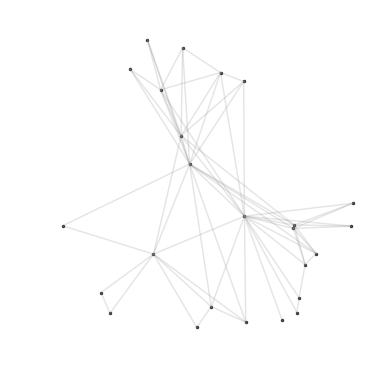

In [11]:
G.plot()

### Initialized (with noise)

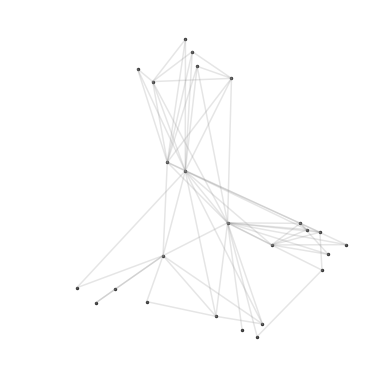

In [12]:
G_init = HRG(R=R, alpha=alpha, T=T)
G_init.r, G_init.theta, G_init.A = r_init, phi_init, A
G_init.plot()

### Estimated

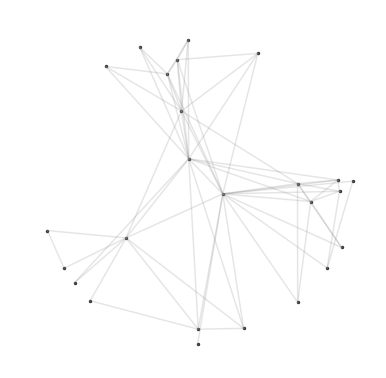

In [13]:
G_post = HRG(R=R_, alpha=alpha_, T=T_)
G_post.r, G_post.theta, G_post.A = rs_, c2d(phis_), A
G_post.plot()